# A Python Notebook for getting charging stations from OpenStreetMap

OpenStreetMap holds information about currently listed charging stations as "nodes" with the tag `amenity=charging_station`.

We are sending a query to the Overpass API to get all nodes with this tag in the "level 2" administrative area of Belgium.

In [1]:
# Importing Python libraries for OSM data extraction and data storage
import pandas as pd
import overpy

# For path management and persisting data in feather format
from pathlib import Path
import pyarrow.feather as feather

# Images in notebooks (for GitHub publishing)
from IPython.display import Image

In [2]:
# We use the Overpass API to query the OpenStreetMap database
overpass_api = overpy.Overpass()

# We query the OSM database for all charging stations in Belgium
results = overpass_api.query(
    """
    [out:json];

    // [out:csv(::id, ::type, ::lat, ::lon, amenity, operator)];
    
    area[admin_level=2]["ISO3166-1"="BE"]->.boundaryarea;      
    (
	    nwr(area.boundaryarea)[amenity=charging_station];
    );
    
    out body;
"""
)

In [3]:
print(f'Number of objects with amenity type "charging_station" in Belgium:')
print(f"{len(results.nodes)} nodes")
print(f"{len(results.ways)} ways")
print(f"{len(results.relations)} relations")

Number of objects with amenity type "charging_station" in Belgium:
2618 nodes
45 ways
0 relations


Storing results in a DataFrame and exporting them to a Feather file

In [4]:
# Creating an empty DataFrame
charging_stations = pd.DataFrame(
    columns=["osm_id", "type", "latitude", "longitude", "amenity", "operator", "tags"]
)

# Creating simple lists from the resultset
nodes = []
for node in results.nodes:
    nodes.append(
        {
            "osm_id": node.id,
            "type": "node",
            "latitude": node.lat,
            "longitude": node.lon,
            "amenity": node.tags["amenity"],
        }
    )

ways = []
for way in results.ways:
    ways.append(
        {
            "osm_id": way.id,
            "type": "way",
            "latitude": way.center_lat,
            "longitude": way.center_lon,
            "amenity": way.tags["amenity"],
        }
    )

relations = []
for relation in results.relations:
    relations.append(
        {
            "osm_id": relation.id,
            "type": "relation",
            "latitude": relation.center_lat,
            "longitude": relation.center_lon,
            "amenity": relation.tags["amenity"],
        }
    )

# Building a DataFrame from the lists
charging_stations = pd.DataFrame(nodes + ways + relations)

In [5]:
feather.write_feather(
    charging_stations,
    Path.joinpath(Path.cwd(), "data", "Charging_Stations_from_OSM.feather"),
)

A quick check if the Feather file looks good

In [6]:
# Reading the feather file
osm_charging_stations = feather.read_feather(
    Path.joinpath(Path.cwd(), "data", "Charging_Stations_from_OSM.feather")
)
osm_charging_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   osm_id     2658 non-null   int64 
 1   type       2658 non-null   object
 2   latitude   2613 non-null   object
 3   longitude  2613 non-null   object
 4   amenity    2658 non-null   object
dtypes: int64(1), object(4)
memory usage: 104.0+ KB


Let's see what we have

In [7]:
# Looking at a few "nodes" only
osm_charging_stations[osm_charging_stations["type"] == "node"].sample(5)

,osm_id,type,latitude,longitude,amenity
1349,9708149927,node,51.2107516,4.5793328,charging_station
1834,10106492049,node,50.8853923,4.3405802,charging_station
197,6019893727,node,51.0665431,5.0895422,charging_station
121,5429382380,node,50.8796708,4.7155126,charging_station
36,4232384015,node,50.4041994,4.4530354,charging_station


## A map of these charging stations

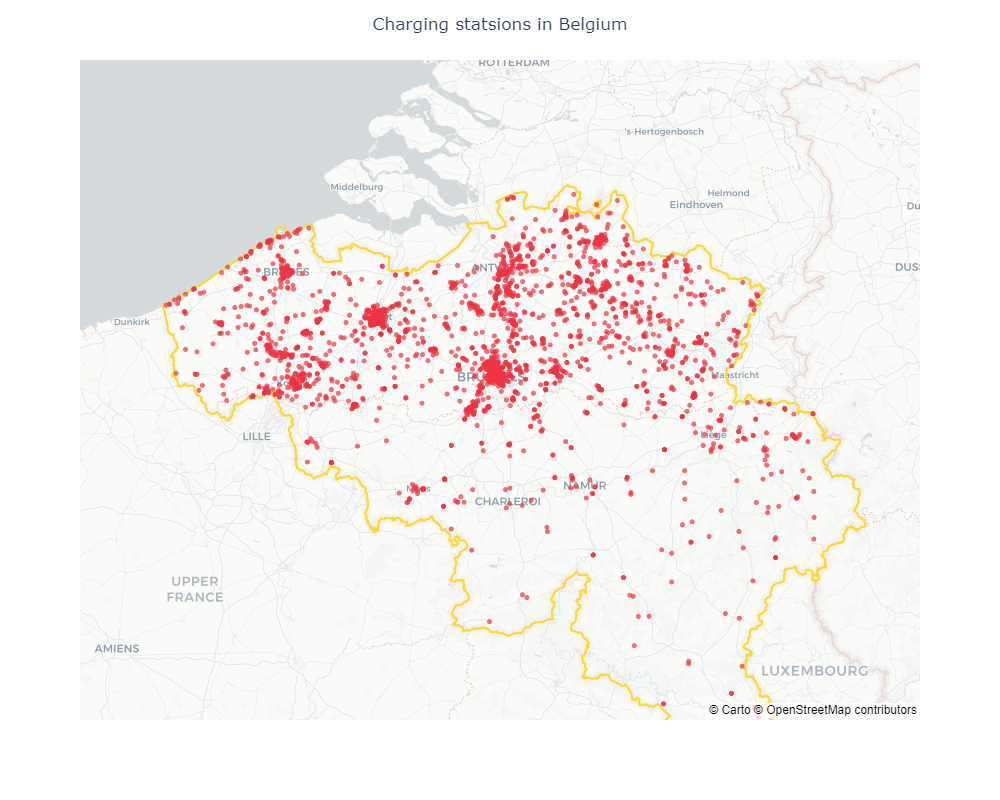

In [8]:
import plotly.express as px
import geopandas as gpd
import json

# Getting the contours of Belgium from the Eurostat shape
belgium_gdf = gpd.read_file(
    Path.joinpath(
        Path.cwd(),
        "data",
        "EUROSTAT-ref-countries-2020-01m-shp",
        "CNTR_RG_01M_2020_4326",
        "CNTR_RG_01M_2020_4326.shp",
    )
)
belgium_gdf = belgium_gdf.to_crs("EPSG:4326")
belgium_gdf = belgium_gdf[belgium_gdf["CNTR_ID"] == "BE"]

# Need to set my MapBox token
px.set_mapbox_access_token(open(".mapbox_token").read())

# Scatter plot of the charging stations
fig = px.scatter_mapbox(
    osm_charging_stations,
    lat="latitude",
    lon="longitude",
    hover_name="osm_id",
    center=dict(lat=50.8, lon=4.4),
    opacity=0.7,
)

fig.update_traces(marker=dict(color="#ef3340"))  # red of the Belgian flag (#ef3340)

# Some map settings and adding a layer with the Belgian border
fig.update_layout(
    title="Charging statsions in Belgium",
    title_x=0.5,
    mapbox={
        "style": "carto-positron",
        "zoom": 7,
        "layers": [
            # Belgian border layer from the Eurostat shape
            {
                "sourcetype": "geojson",
                "source": json.loads(
                    belgium_gdf.geometry.to_json()
                ),  # we need to use json.loads to convert the string to a proper Python dictionary
                "below": "traces",
                "type": "line",
                "color": "#fdda24",  # yellow of the Belgian flag (#fdda24)
                "line": {"width": 2.0},
            }
        ],
    },
    paper_bgcolor="#ffffff",
    height=800,
    width=1000,
)

#fig.show()
# Instead of Plotly show() we can also take the bytes of the image and display it in the notebook directly using Image
img_bytes = fig.to_image(format="png")
Image(img_bytes)